### Packages to use
`-- pip3 install pymc3` to install pymc3 <br>
`-- pip3 install arviz` to install arviz (used to visualise pymc3 results) <br>
`-- pip3 install graphviz` to install python-graphviz (which is used by some arviz functions)

In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import corner

### Constants

In [2]:
G = 4.301e-9
# G = 4.49975e-6
H = 67.6
Dc = 200.
b, g = 2., 3. 

### Functions to implement the DZ and NFW models

In [14]:
def Vvir(Mh):
    return np.sqrt((Dc*(H)**2/2.)**(1./3.) * (G*Mh)**(2./3.))

def Mvir(Vh):
    return np.sqrt(2./Dc)/G/H * Vh**3

def Rvir(Mh):
    rho_c = 3. * (H)**2 / (8. * np.pi * G)
    rho_hat = 4. / 3. * np.pi * Dc * rho_c
    return 1e3 * np.power(Mh / rho_hat, 1./3.)

def mu(c, a, b, g):
    return np.power(1.+np.power(c,1./b),b*(g-a))/np.power(c,3.-a)

### circular velocity of Dekel Zaho halo as a function of a and c
def vc_dz(r, Mh, a, cc):
    rvir = Rvir(Mh)
    r1 = 0.01 * rvir
    rs = rvir/cc
    x = r/rs
    Vvir2 = Vvir(Mh)**2
    return np.sqrt(Vvir2*mu(cc, a, b, g)*cc*np.power(x,2.-a)/np.power(1.+np.power(x,1./b),b*(g-a)))

### NFW functions (c, Vc, & auxiliary function fc)
def c_func(M): # from Dutton & Maccio' (2014) -- with c_200
    return 10.**(0.905 - 0.101 * (np.log10(M*H/100.)-12))

def vc_nfw(R, Mh, cc):
    return np.sqrt(Vvir(Mh)**2*Rvir(Mh)/R*fc(cc*R/Rvir(Mh))/fc(cc))

def fc(x):
    return np.log(1+x)-x/(1+x)

### Constructing the models

In [15]:
rotcurve = np.loadtxt("NGC5055_rotmod.dat", unpack=True, comments='#')


with pm.Model() as nfw_model:
    data  = pm.Data('data', rotcurve)
    ### logMh & logml are uniformly chosen between certain values,
    ### while logc is a Normal (Gaussian) distribution whose mean value is given by c_func 
    logMh = pm.Uniform('logMh', lower=0., upper=20., testval=12.)
    logml = pm.Uniform('logml', lower=-2., upper=2., testval=-0.3)
    logc  = pm.Normal('logc', mu=pm.math.log(c_func(10**logMh)), sigma=0.11, testval=1.0)
    
    radius = data[0]
    vobs, e_vobs = data[1], data[2]
    vgas, vdisc, vbulge = data[3], data[4], data[5]
    
    ### We determine the baryonic and total velocities from the priors above
    vbar = np.sqrt(vgas**2 + 10**logml * vdisc**2 + 1.4 * 10**logml * vbulge**2)
    vmodel = np.sqrt(vc_nfw(radius, 10**logMh, 10**logc)**2 + vbar**2)
    
    v_mod = pm.Normal('v_mod', mu=vmodel, tau=1./e_vobs**2, observed=vobs)

with pm.Model() as dz_model:
    ### We build a second model for the DZ profile, based on logMh, a, c and logml
    data  = pm.Data('data', rotcurve)
    logMh = pm.Uniform('logMh', lower=0., upper=20., testval=12.)
    apar = pm.Uniform('a', lower=-5., upper=2.)
    logml = pm.Uniform('logml', lower=-2., upper=2., testval=-0.3)
    logc = pm.Normal('logc', mu=pm.math.log(c_func(10**logMh)), sigma=0.11, testval=1.0)
    
    radius = data[0]
    vobs, e_vobs = data[1], data[2]
    vgas, vdisc, vbulge = data[3], data[4], data[5]
    
    vbar = np.sqrt(vgas**2 + 10**logml * vdisc**2 + 1.4 * 10**logml * vbulge**2)
    vmodel = np.sqrt(vc_dz(radius, 10**logMh, apar, 10**logc)**2 + vbar**2)
    
    v_mod = pm.Normal('v_mod', mu=vmodel, tau=1./e_vobs**2, observed=vobs)
    

### Running MCMC on the models above

In [16]:
### Because our priors are continuous variables, we choose the No U-turn Sampler (NUTS) algorithm
nsamples, ntune = 4000, 2000

print('Running MCMC on the DZ model')
with dz_model:
    dz_trace = pm.sample(draws=nsamples, tune=ntune, step=pm.NUTS(), discard_tuned_samples=True, return_inferencedata=False)

print('Running MCMC on the NFW model')
with nfw_model:
    nfw_trace = pm.sample(draws=nsamples, step=pm.NUTS(), tune=ntune, discard_tuned_samples=True, return_inferencedata=False)

Running MCMC on the DZ model


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logc, logml, a, logMh]
INFO:pymc3:NUTS: [logc, logml, a, logMh]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 47 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 47 seconds.
There were 2139 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2139 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1312057623404406, but should be close to 0.8. Try to increase the number of tuning steps.
There were 872 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 872 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5536957759218738, but should be close to 0.8. Try to increase the number of tuning steps.
There were 757 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7

Running MCMC on the NFW model


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logc, logml, logMh]
INFO:pymc3:NUTS: [logc, logml, logMh]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 31 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 31 seconds.
The acceptance probability does not match the target. It is 0.8830265452237868, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6732306671539432, but should be close to 0.8. Try to increase the number of tuning steps.
There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5378181606278638, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is s

### Visualisation of the distributions

In [12]:
### Uncomment to see how the NFW variables are structured
# pm.model_to_graphviz(nfw_model)

In [13]:
### Uncomment to see how the DZ variables are structured
# pm.model_to_graphviz(dz_model)

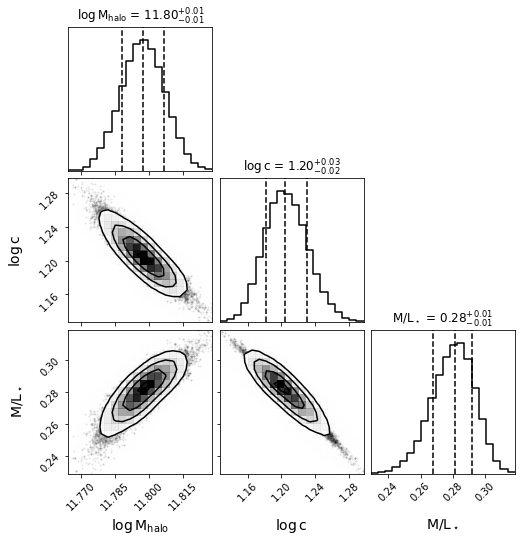

In [19]:
### We visualise the distribution of the NFW parameters
nfw_samples = pm.trace_to_dataframe(nfw_trace)
nfw_samples['logml'] = 10**nfw_samples['logml']
nfw_samples.rename(columns={'logml':'ml'}, inplace=True)
nfw_samples = nfw_samples[['logMh', 'logc', 'ml']]
corner.corner(nfw_samples, divergences=False, labels=[r"$\rm\log\,M_{halo}$", r"$\rm\log\,c$", r"$\rm M/L_\star$"],
              quantiles=[.16,.50,.84], show_titles=True, smooth=1., smooth1d=1., label_kwargs={'fontsize':14})
plt.show()

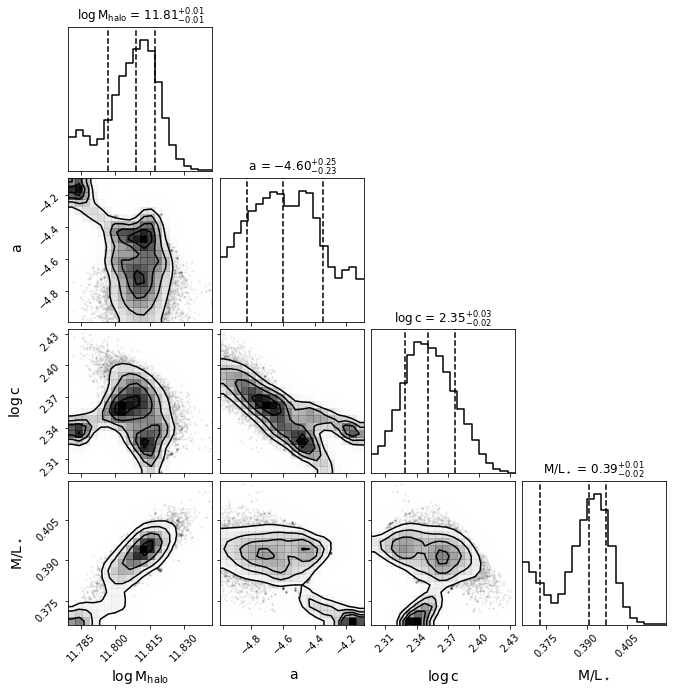

In [17]:
### We visualise the distribution of the DZ parameters
dz_samples = pm.trace_to_dataframe(dz_trace)
dz_samples['logml'] = 10**dz_samples['logml']
dz_samples.rename(columns={'logml':'ml'}, inplace=True)
dz_samples = dz_samples[['logMh', 'a', 'logc', 'ml']]

fig1 = corner.corner(dz_samples, divergences=False, labels=[r"$\rm\log\,M_{halo}$", r"$\rm\ a$", r"$\rm\log\,c$", r"$\rm M/L_\star$"],
              quantiles=[.16,.50,.84], show_titles=True, smooth=1., smooth1d=1., label_kwargs={'fontsize':14})
plt.show()

### Visualisation of the fits

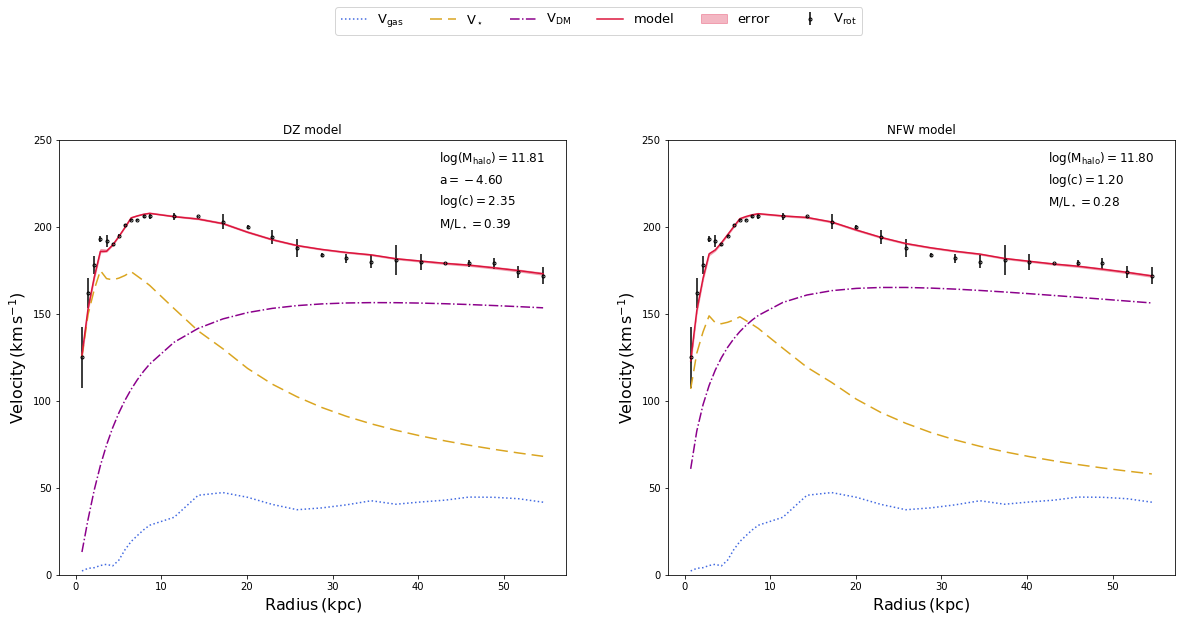

In [20]:
Mh_dz, a_dz, c_dz, ml_dz = np.median(10**dz_samples['logMh']), np.median(dz_samples['a']), np.median(10**dz_samples['logc']), np.mean(dz_samples['ml'])
Mh_nfw, c_nfw, ml_nfw = np.median(10**nfw_samples['logMh']), np.median(10**nfw_samples['logc']), np.median(nfw_samples['ml'])

radii, vrot_obs, evrot_obs, vgas_obs, vdisc_obs, vbulge_obs, _, _ = rotcurve
vstar_dz = np.sqrt(ml_dz * vdisc_obs**2 + 1.4 * ml_dz * vbulge_obs**2)
vstar_nfw = np.sqrt(ml_nfw * vdisc_obs**2 + 1.4 * ml_nfw * vbulge_obs**2)

vdm_dz = vc_dz(radii, Mh_dz, a_dz, c_dz)
vdm_nfw = vc_nfw(radii, Mh_nfw, c_nfw)

vtot_dz = np.sqrt(vstar_dz**2 + vgas_obs**2 + vdm_dz**2)
vtot_nfw = np.sqrt(vstar_nfw**2 + vgas_obs**2 + vdm_nfw**2)

vms_dz = [np.sqrt(dz_samples['ml'][k]*vdisc_obs**2 + 1.4*dz_samples['ml'][k]*vbulge_obs**2 + vgas_obs**2 +
                        vc_dz(radii, 10**dz_samples['logMh'][k], dz_samples['a'][k], 10**dz_samples['logc'][k])**2) for k in range(len(dz_samples))]

vms_nfw = [np.sqrt(nfw_samples['ml'][k]*vdisc_obs**2 + 1.4*nfw_samples['ml'][k]*vbulge_obs**2 + vgas_obs**2 +
                        vc_nfw(radii, 10**nfw_samples['logMh'][k], 10**nfw_samples['logc'][k])**2) for k in range(len(nfw_samples))]

fig, axs = plt.subplots(1,2, figsize=(20,8))

axs[0].errorbar(radii, vrot_obs, yerr=evrot_obs, fmt='.', mfc='none', label=r"$\rm V_{rot}$", c='k')
axs[0].plot(radii, vgas_obs, color='royalblue', ls=":", label=r"$\rm V_{gas}$")
axs[0].plot(radii, vstar_dz, color='goldenrod', dashes=[8, 4], label=r"$\rm V_\star$")
axs[0].plot(radii, vdm_dz, c='darkmagenta', ls="-.", label=r"$\rm V_{DM}$")
axs[0].plot(radii, vtot_dz, c='crimson', label=r"$\rm model$")
axs[0].fill_between(radii, np.median(vms_dz,axis=0)+np.std(vms_dz,axis=0), np.median(vms_dz,axis=0)-np.std(vms_dz,axis=0),
                color='crimson', alpha=0.3, label=r'$\rm error$')
axs[0].set_xlabel(r"$\rm Radius\,(kpc)$", fontsize=16);
axs[0].set_ylabel(r"$\rm Velocity\,(km\,s^{-1})$", fontsize=16)
axs[0].set_ylim(0.,250.)
axs[0].text(0.75,0.95, r'$\rm \log(M_{halo}) = %.2f$' %np.log10(Mh_dz), fontsize=12, transform=axs[0].transAxes)
axs[0].text(0.75,0.9, r'$\rm a = %.2f$' %a_dz, fontsize=12, transform=axs[0].transAxes)
axs[0].text(0.75,0.85, r'$\rm \log(c) = %.2f$' %np.log10(c_dz), fontsize=12, transform=axs[0].transAxes)
axs[0].text(0.75,0.8, r'$\rm M/L_\star = %.2f$' %ml_dz, fontsize=12, transform=axs[0].transAxes)
axs[0].set_title('DZ model')

axs[1].errorbar(radii, vrot_obs, yerr=evrot_obs, fmt='.', mfc='none',c='k')
axs[1].plot(radii, vgas_obs, color='royalblue', ls=":")
axs[1].plot(radii, vstar_nfw, color='goldenrod', dashes=[8, 4])
axs[1].plot(radii, vdm_nfw, c='darkmagenta', ls="-.")
axs[1].plot(radii, vtot_nfw, c='crimson')
axs[1].fill_between(radii, np.median(vms_nfw,axis=0)+np.std(vms_nfw,axis=0), np.median(vms_nfw,axis=0)-np.std(vms_nfw,axis=0),
                color='crimson', alpha=0.3)
axs[1].set_xlabel(r"$\rm Radius\,(kpc)$", fontsize=16);
axs[1].set_ylabel(r"$\rm Velocity\,(km\,s^{-1})$", fontsize=16);
axs[1].set_ylim(0.,250.)
axs[1].text(0.75,0.95, r'$\rm \log(M_{halo}) = %.2f$' %np.log10(Mh_nfw), fontsize=12, transform=axs[1].transAxes)
axs[1].text(0.75,0.9, r'$\rm \log(c) = %.2f$' %np.log10(c_nfw), fontsize=12, transform=axs[1].transAxes)
axs[1].text(0.75,0.85, r'$\rm M/L_\star = %.2f$' %ml_nfw, fontsize=12, transform=axs[1].transAxes)
axs[1].set_title('NFW model')

lines_labels = [ax.get_legend_handles_labels() for ax in axs]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', fontsize=13, bbox_to_anchor=(-0.1, 1.02, 1.2, .102), ncol=6)